In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

In [2]:
from fastai2.basics import *
from fastai2.vision.augment import *
from fastai2.vision.core import *
from fastai2.vision.data import *
from fastai2.data.all import *
from src.multichannel import *
from src.customnets import SimpleNet
import geopandas as gpd
import xarray as xr
from src.spectral_variables import * 
plt.style.use('seaborn-paper')

# Compare differences between individual models and ensemble of models

In [62]:
learn_path = Path('fastai_models/')
models = ['2m_relu_fixed', '3m_relu_fixed', '4m_relu_fixed', '5m_relu_fixed']
tile_path = Path('data/tiles')
shape_path = Path('data/delineated_tiles/')

In [4]:
test_trees = gpd.read_file('data/tree_cubes_10m_fixed/5m/test.shp')

## Run preditions for individual models

Use only trees from 5m cubes, so that models are evaluated here with exactly same data.

In [5]:
cmtxs = []
sum_preds = None
for model in models:
    learn = load_learner(learn_path/model/'export.pkl', cpu=False)
    test_dl = learn.dls.test_dl(test_trees, with_labels=True, bs=1)
    test_interp = ClassificationInterpretation.from_learner(learn, dl=test_dl)
    preds = learn.get_preds(ds_idx=0, dl=test_dl)
    if sum_preds is None: sum_preds = preds[0]
    else: sum_preds += preds[0]
    print(model)
    test_interp.print_classification_report()
    cmtxs.append(test_interp.confusion_matrix())

2m_relu_fixed
                precision    recall  f1-score   support

         Birch       0.70      0.83      0.76        70
European aspen       0.93      0.88      0.90        81
 Norway spruce       0.92      0.83      0.87       206
    Scots pine       0.86      0.93      0.90       164

      accuracy                           0.87       521
     macro avg       0.85      0.87      0.86       521
  weighted avg       0.87      0.87      0.87       521



3m_relu_fixed
                precision    recall  f1-score   support

         Birch       0.70      0.81      0.75        70
European aspen       0.93      0.78      0.85        81
 Norway spruce       0.90      0.85      0.88       206
    Scots pine       0.87      0.95      0.91       164

      accuracy                           0.86       521
     macro avg       0.85      0.85      0.85       521
  weighted avg       0.87      0.86      0.86       521



4m_relu_fixed
                precision    recall  f1-score   support

         Birch       0.75      0.73      0.74        70
European aspen       0.92      0.85      0.88        81
 Norway spruce       0.87      0.83      0.85       206
    Scots pine       0.84      0.93      0.88       164

      accuracy                           0.85       521
     macro avg       0.84      0.83      0.84       521
  weighted avg       0.85      0.85      0.85       521



5m_relu_fixed
                precision    recall  f1-score   support

         Birch       0.69      0.71      0.70        70
European aspen       0.92      0.80      0.86        81
 Norway spruce       0.88      0.85      0.86       206
    Scots pine       0.86      0.93      0.89       164

      accuracy                           0.85       521
     macro avg       0.84      0.82      0.83       521
  weighted avg       0.85      0.85      0.85       521



In [6]:
def make_confusion_matrix(cm, ax, title, vocab):
    ax.imshow(cm, interpolation='nearest', cmap='Blues')
    ax.set_title(title)
    tick_marks = np.arange(len(vocab))
    ax.tick_params(axis='x', rotation=90)
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(vocab)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(vocab)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        coeff = f'{cm[i, j]}'
        ax.text(j, i, coeff, horizontalalignment="center", verticalalignment="center", color="white" if cm[i, j] > thresh else "black")
    ax.grid(False)
    return ax

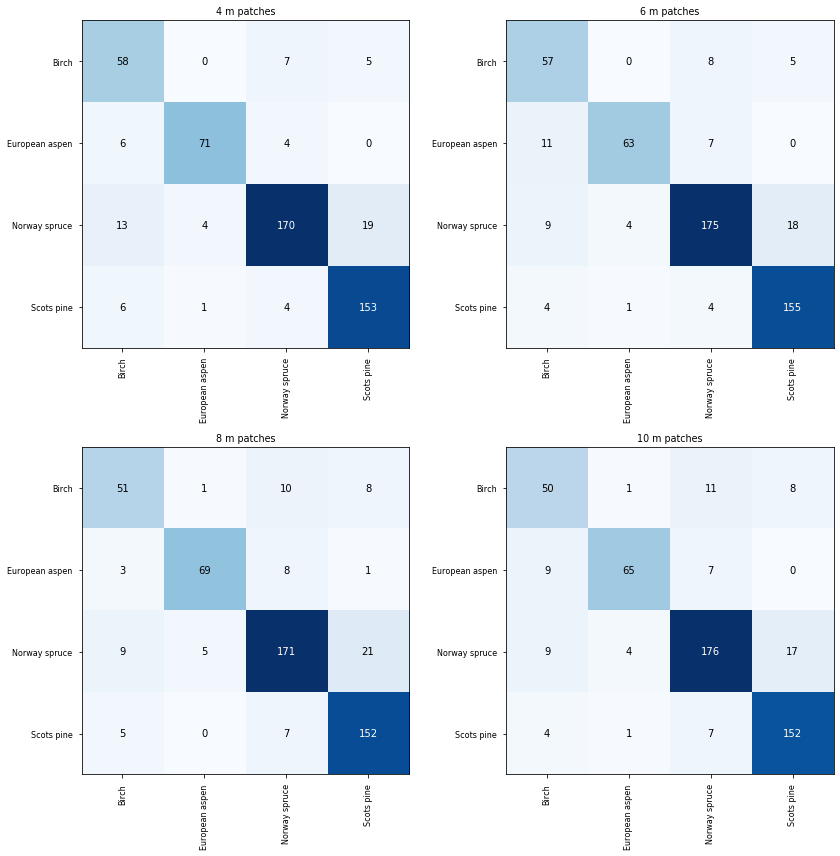

In [7]:
fig, axs = plt.subplots(2,2, figsize=(12,12))
make_confusion_matrix(cmtxs[0], axs[0,0], title='4 m patches', vocab=test_dl.vocab)
make_confusion_matrix(cmtxs[1], axs[0,1], title='6 m patches', vocab=test_dl.vocab)
make_confusion_matrix(cmtxs[2], axs[1,0], title='8 m patches', vocab=test_dl.vocab)
make_confusion_matrix(cmtxs[3], axs[1,1], title='10 m patches', vocab=test_dl.vocab)
plt.tight_layout()

## Inspect predictions for ensemble of models

In [8]:
from sklearn.metrics import classification_report, confusion_matrix

In [9]:
print(classification_report(preds[1], sum_preds.argmax(axis=1), target_names = test_dl.vocab))

                precision    recall  f1-score   support

         Birch       0.71      0.76      0.73        70
European aspen       0.91      0.84      0.87        81
 Norway spruce       0.89      0.83      0.86       206
    Scots pine       0.87      0.94      0.90       164

      accuracy                           0.86       521
     macro avg       0.84      0.84      0.84       521
  weighted avg       0.86      0.86      0.86       521



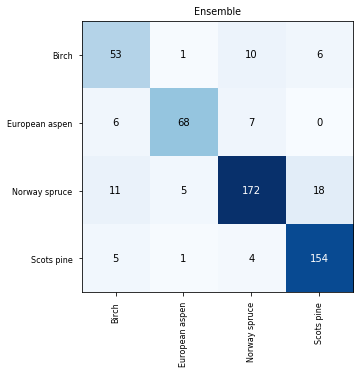

In [10]:
fig, axs = plt.subplots(1,1, figsize=(5,5))
make_confusion_matrix(confusion_matrix(preds[1], sum_preds.argmax(axis=1)), axs, title='Ensemble', vocab=test_dl.vocab)
plt.show()

At least for validation data, the ensemble of all models performs slightly worse than best individual model.

# Predict full tiles with different models and check the differences

In [11]:
def get_trees(df, tile, window_size):
    cubes = []
    for tree in df.itertuples():
        ymax_tile = max(tile.coords.variables['y'].values)
        ymin_tile = min(tile.coords.variables['y'].values)
        xmax_tile = max(tile.coords.variables['x'].values)
        xmin_tile = min(tile.coords.variables['x'].values)
        x_coord = tree.ttop_x
        y_coord = tree.ttop_y
        ymax = y_coord + window_size
        ymin = y_coord - window_size 
        xmax = x_coord + window_size
        xmin = x_coord - window_size
        cropped = tile.sel(y=slice(ymax, ymin), x=slice(xmin, xmax)).copy()
        cropped = cropped.values

        # Check that square image was extracted
        if cropped.shape[1] != (4*window_size) or cropped.shape[2] != (4*window_size): 
            # Check where to pad
            x_left, x_right, y_top, y_bot = 0,0,0,0
            if ymax > ymax_tile:
                y_top = int((ymax - ymax_tile) * 2)
            if xmax > xmax_tile:
                x_right = int((xmax - xmax_tile) * 2)
            if ymin < ymin_tile:
                y_bot = int((ymin_tile - ymin) * 2)
            if xmin < xmin_tile:
                x_left = int((xmin_tile - xmin) * 2)
            cropped = np.pad(cropped, ((0,0), (y_top, y_bot), (x_left, x_right)), 'reflect')
        cubes.append(MultiChannelTensorImage.create(cropped))
    return cubes

In [63]:
tile_id = 'R8C19'
shape = gpd.read_file(str(shape_path/tile_id)+'.shp')
tile = xr.open_rasterio(str(tile_path/tile_id)+'.tif')[used_band_idxs]
tile

<xarray.DataArray (band: 250, y: 1000, x: 1000)>
[250000000 values with dtype=float32]
Coordinates:
  * band     (band) int64 1 2 3 4 5 6 7 8 9 ... 330 331 332 333 334 335 336 337
  * y        (y) float64 6.792e+06 6.792e+06 6.792e+06 ... 6.791e+06 6.791e+06
  * x        (x) float64 4.018e+05 4.018e+05 4.018e+05 ... 4.023e+05 4.023e+05
Attributes:
    transform:   (0.5, 0.0, 401758.5, 0.0, -0.5, 6791732.5)
    res:         (0.5, 0.5)
    is_tiled:    0
    nodatavals:  (nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,...
    scales:      (1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...
    offsets:     (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...

In [64]:
for model, ws in zip(models, [2,3,4,5]):
    learn = load_learner(learn_path/model/'export.pkl', cpu=False)
    tile_dl = learn.dls.test_dl(get_trees(shape, tile, ws), with_labels=False)
    preds = learn.get_preds(ds_idx=0, dl=tile_dl, with_decoded=True, with_loss=False)
    shape[model] = [learn.dls.vocab[i] for i in preds[2]]
    shape[f'birch_proba_{model}'] = preds[0][:,0]
    shape[f'aspen_proba_{model}'] = preds[0][:,1]
    shape[f'spruce_proba_{model}'] = preds[0][:,2]
    shape[f'pine_proba_{model}'] = preds[0][:,3]

Check prediction statistics for each model

In [65]:
shape['2m_relu_fixed'].value_counts(normalize=True)

Scots pine        0.555701
Birch             0.312836
Norway spruce     0.119164
European aspen    0.012299
Name: 2m_relu_fixed, dtype: float64

In [66]:
shape['3m_relu_fixed'].value_counts(normalize=True)

Scots pine        0.535164
Birch             0.287881
Norway spruce     0.164537
European aspen    0.012418
Name: 3m_relu_fixed, dtype: float64

In [67]:
shape['4m_relu_fixed'].value_counts(normalize=True)

Scots pine        0.551881
Birch             0.246448
Norway spruce     0.179463
European aspen    0.022209
Name: 4m_relu_fixed, dtype: float64

In [68]:
shape['5m_relu_fixed'].value_counts(normalize=True)

Scots pine        0.525134
Birch             0.294328
Norway spruce     0.167761
European aspen    0.012776
Name: 5m_relu_fixed, dtype: float64

Larger patches seem to predict aspen more frequently.

Plot results

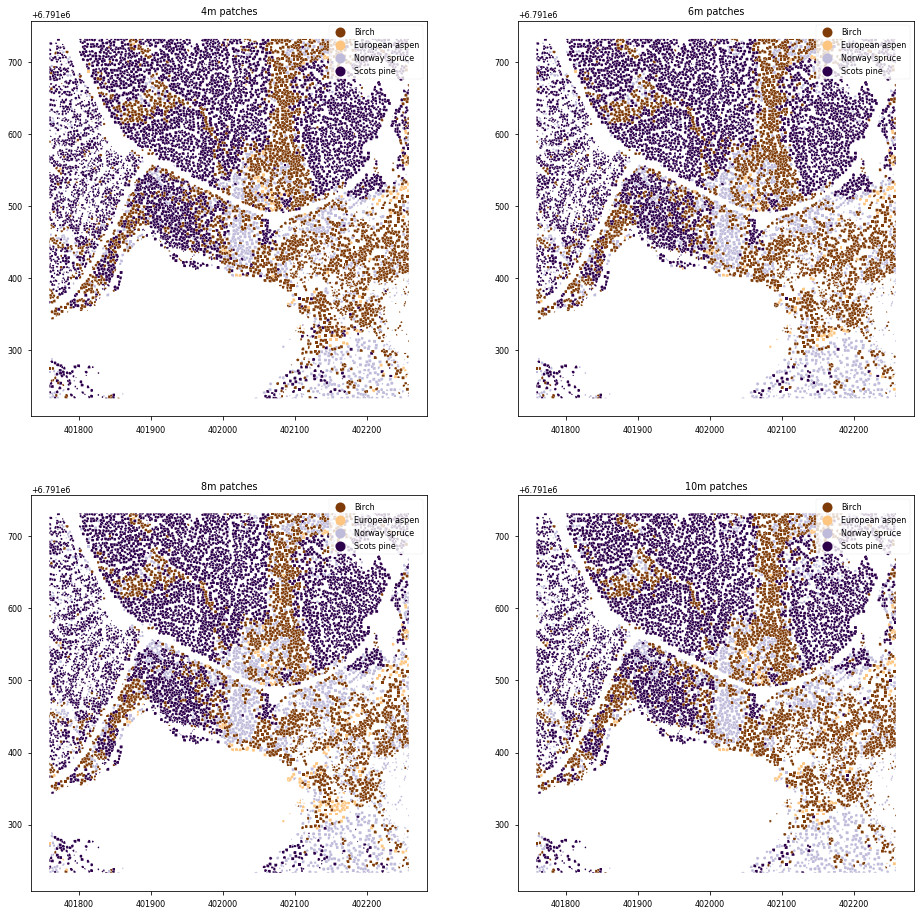

In [69]:
fig, axs = plt.subplots(2,2, figsize=(16,16))
shape.plot(column='2m_relu_fixed', ax=axs[0,0], legend=True, cmap='PuOr').set_title('4m patches')
shape.plot(column='3m_relu_fixed', ax=axs[0,1], legend=True, cmap='PuOr').set_title('6m patches')
shape.plot(column='4m_relu_fixed', ax=axs[1,0], legend=True, cmap='PuOr').set_title('8m patches')
shape.plot(column='5m_relu_fixed', ax=axs[1,1], legend=True, cmap='PuOr').set_title('10m patches')
plt.show()

Check differences in species probabilities between models

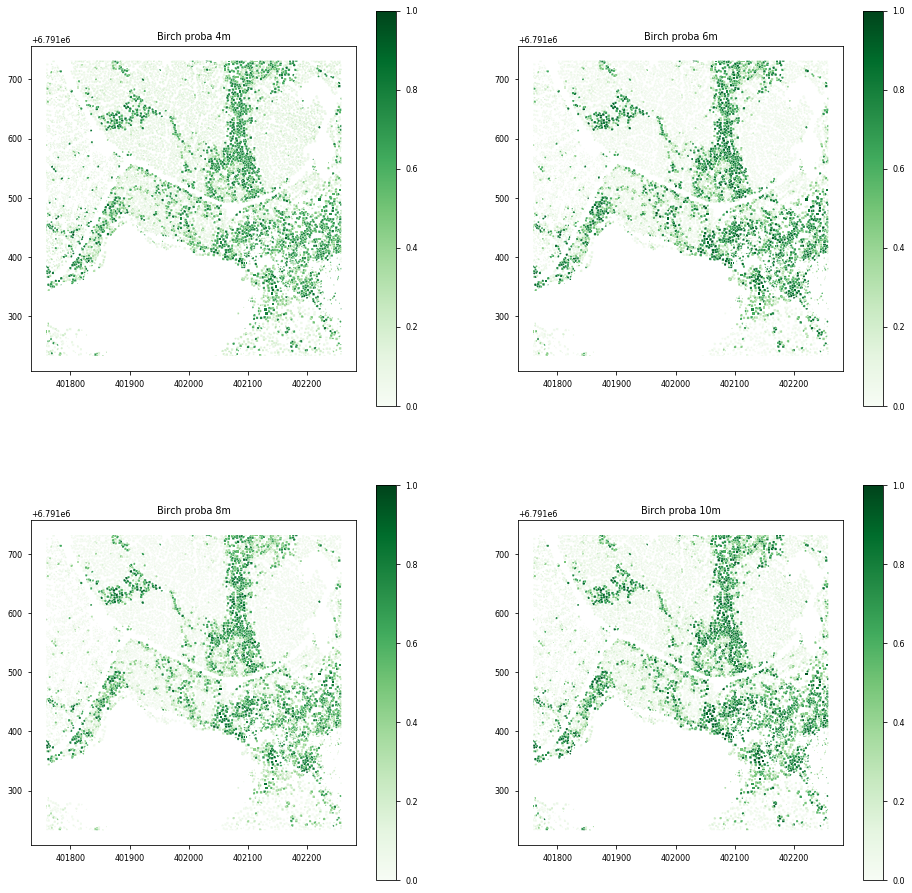

In [70]:
fig, axs = plt.subplots(2,2, figsize=(16,16))
shape.plot(column='birch_proba_2m_relu_fixed', ax=axs[0,0], legend=True, cmap='Greens', vmin=0, vmax=1).set_title('Birch proba 4m')
shape.plot(column='birch_proba_3m_relu_fixed', ax=axs[0,1], legend=True, cmap='Greens', vmin=0, vmax=1).set_title('Birch proba 6m')
shape.plot(column='birch_proba_4m_relu_fixed', ax=axs[1,0], legend=True, cmap='Greens', vmin=0, vmax=1).set_title('Birch proba 8m')
shape.plot(column='birch_proba_5m_relu_fixed', ax=axs[1,1], legend=True, cmap='Greens', vmin=0, vmax=1).set_title('Birch proba 10m')
plt.show()

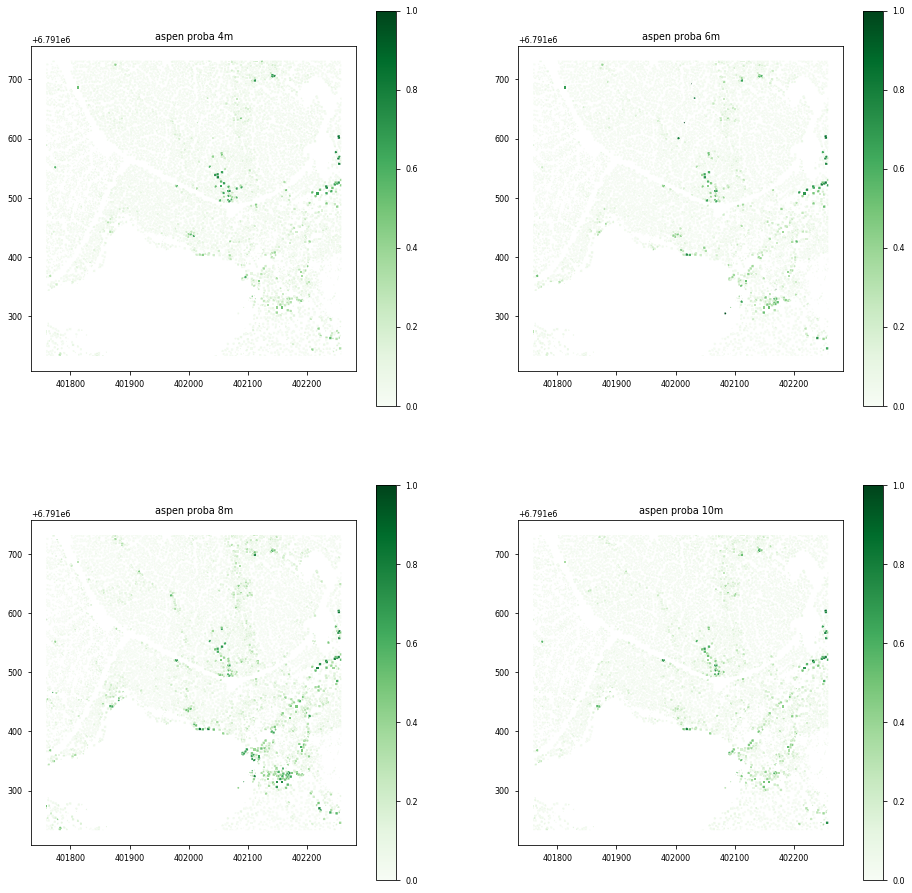

In [71]:
fig, axs = plt.subplots(2,2, figsize=(16,16))
shape.plot(column='aspen_proba_2m_relu_fixed', ax=axs[0,0], legend=True, cmap='Greens', vmin=0, vmax=1).set_title('aspen proba 4m')
shape.plot(column='aspen_proba_3m_relu_fixed', ax=axs[0,1], legend=True, cmap='Greens', vmin=0, vmax=1).set_title('aspen proba 6m')
shape.plot(column='aspen_proba_4m_relu_fixed', ax=axs[1,0], legend=True, cmap='Greens', vmin=0, vmax=1).set_title('aspen proba 8m')
shape.plot(column='aspen_proba_5m_relu_fixed', ax=axs[1,1], legend=True, cmap='Greens', vmin=0, vmax=1).set_title('aspen proba 10m')
plt.show()

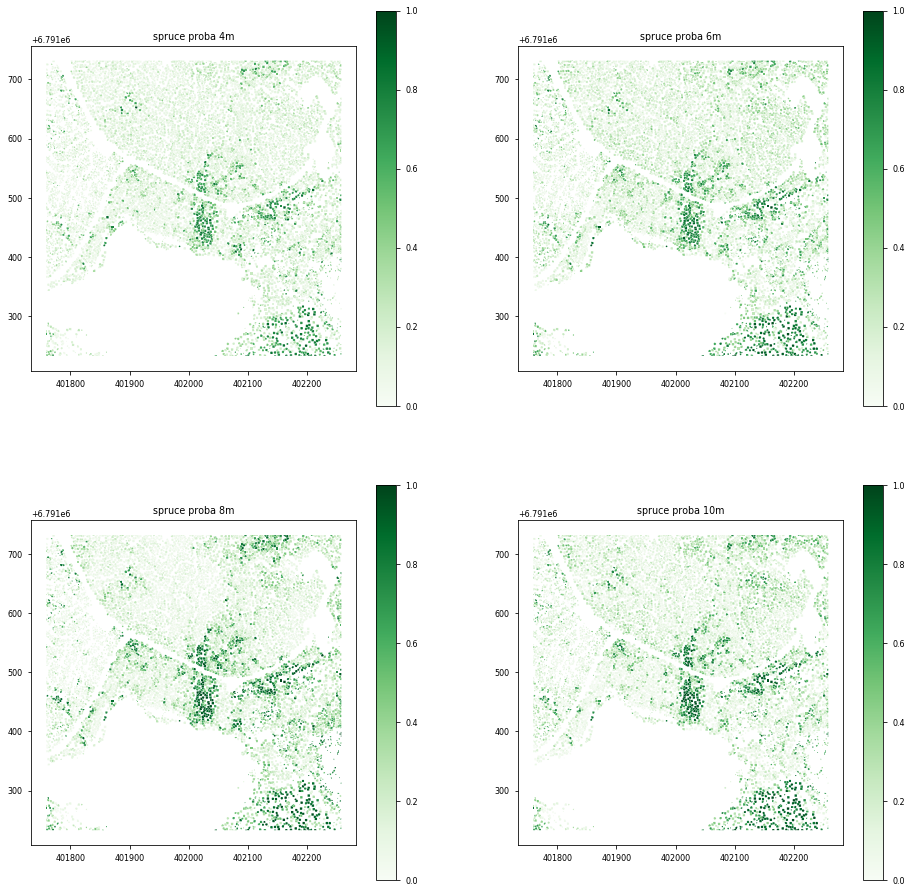

In [72]:
fig, axs = plt.subplots(2,2, figsize=(16,16))
shape.plot(column='spruce_proba_2m_relu_fixed', ax=axs[0,0], legend=True, cmap='Greens', vmin=0, vmax=1).set_title('spruce proba 4m')
shape.plot(column='spruce_proba_3m_relu_fixed', ax=axs[0,1], legend=True, cmap='Greens', vmin=0, vmax=1).set_title('spruce proba 6m')
shape.plot(column='spruce_proba_4m_relu_fixed', ax=axs[1,0], legend=True, cmap='Greens', vmin=0, vmax=1).set_title('spruce proba 8m')
shape.plot(column='spruce_proba_5m_relu_fixed', ax=axs[1,1], legend=True, cmap='Greens', vmin=0, vmax=1).set_title('spruce proba 10m')
plt.show()

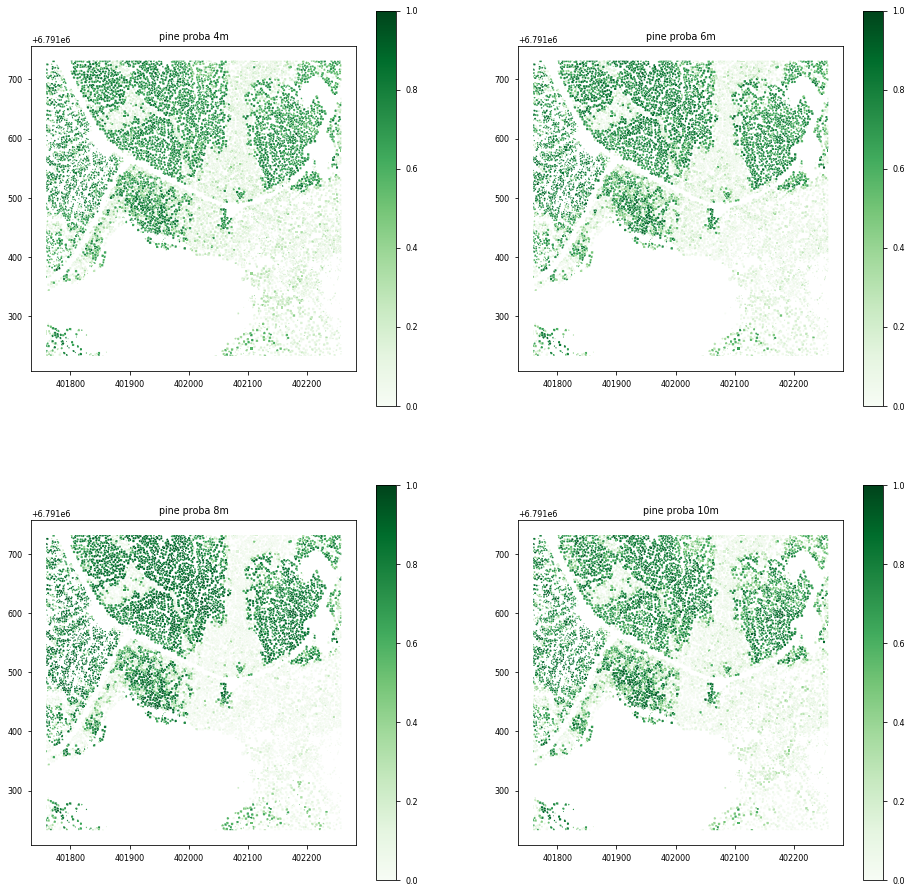

In [73]:
fig, axs = plt.subplots(2,2, figsize=(16,16))
shape.plot(column='pine_proba_2m_relu_fixed', ax=axs[0,0], legend=True, cmap='Greens', vmin=0, vmax=1).set_title('pine proba 4m')
shape.plot(column='pine_proba_3m_relu_fixed', ax=axs[0,1], legend=True, cmap='Greens', vmin=0, vmax=1).set_title('pine proba 6m')
shape.plot(column='pine_proba_4m_relu_fixed', ax=axs[1,0], legend=True, cmap='Greens', vmin=0, vmax=1).set_title('pine proba 8m')
shape.plot(column='pine_proba_5m_relu_fixed', ax=axs[1,1], legend=True, cmap='Greens', vmin=0, vmax=1).set_title('pine proba 10m')
plt.show()